# Analysis of Prosacco Data (Inventory, Orders, Production Plan)

This notebook loads the provided Excel file and performs:
1. Data Preparation
2. Descriptive Analysis
3. Demand vs Supply Analysis
4. Warehouse & Logistics Analysis
5. Financial Analysis
6. Customer & Market Insights
7. Production Plan Efficiency
8. Visualizations

In [3]:
# ----------------------
# 1. Setup & Load Data
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt

# Load Excel file
file_path = "data/Prosacco-analysis-solution.xlsx"  # <-- make sure the file is in the same folder
excel_data = pd.ExcelFile(file_path)

# Load datasets
data1 = pd.read_excel(file_path, sheet_name="Data1", skiprows=2)   # Inventory
data2 = pd.read_excel(file_path, sheet_name="Data2", skiprows=2)   # Orders
data3 = pd.read_excel(file_path, sheet_name="Data3", skiprows=2)   # Production Plan

# Clean and rename columns based on actual structure
# Data1 (Inventory) - drop unnamed column and rename
data1 = data1.drop('Unnamed: 0', axis=1)
data1.columns = ["Category", "SKU", "Warehouse", "Available"]

# Data2 (Orders) - drop unnamed column and rename with correct column names
data2 = data2.drop('Unnamed: 0', axis=1)
data2.columns = ["Country", "City", "PO/ORDER#", "Category", "SKU", "Qty Ordered", 
                 "Channel", "Warehouse", "Delivery Type", "Customer", "Sales $", "Expected Date"]

# Data3 (Production Plan) - clean up and rename
data3 = data3.drop(['Unnamed: 0', 'Unnamed: 15'], axis=1)
# Rename first column to SKU and keep week numbers as they are
week_columns = ['SKU'] + [f'Week_{col}' for col in data3.columns[1:]]
data3.columns = week_columns

# Convert datatypes
data2["Expected Date"] = pd.to_datetime(data2["Expected Date"], errors="coerce")
data2["Qty Ordered"] = pd.to_numeric(data2["Qty Ordered"], errors="coerce")
data2["Sales $"] = pd.to_numeric(data2["Sales $"], errors="coerce")

print("Data cleaning completed successfully!")
print("Data1 shape:", data1.shape)
print("Data2 shape:", data2.shape) 
print("Data3 shape:", data3.shape)

Data cleaning completed successfully!
Data1 shape: (12, 4)
Data2 shape: (2880, 12)
Data3 shape: (12, 14)


In [4]:
# ----------------------
# 2. Descriptive Analysis
# ----------------------
print("Inventory Snapshot:\n", data1.head())
print("\nCustomer Orders Snapshot:\n", data2.head())
print("\nProduction Plan Snapshot:\n", data3.head())

# Inventory summary
inventory_summary = data1.groupby("Category")["Available"].sum().reset_index()
print("\nTotal Inventory by Category:\n", inventory_summary)

# Orders summary
orders_summary = data2.groupby("Category")["Qty Ordered"].sum().reset_index()
print("\nTotal Orders by Category:\n", orders_summary)

Inventory Snapshot:
            Category     SKU Warehouse  Available
0    Fresh Packaged  FP2020      Kern       4063
1    Fresh Packaged  FP3055      Kern       2032
2  Healthy Beverage  HB0156      Kern        148
3  Healthy Beverage  HB1016      Kern       4974
4           Healthy  HT1045      Kern        121

Customer Orders Snapshot:
          Country           City  PO/ORDER#          Category     SKU  \
0  United States  New York City     102981    Fresh Packaged  FP2020   
1  United States  New York City     102980    Organic Beauty  OY2545   
2  United States    Los Angeles     102979    Organic Beauty  OY2545   
3  United States    Los Angeles     102978  Healthy Beverage  HB1016   
4  United States    Los Angeles     102977           Healthy  HT1064   

   Qty Ordered Channel Warehouse Delivery Type   Customer  Sales $  \
0           52  Retail      Kern      Delivery  Customer1     6500   
1           52  Retail      Kern      Delivery  Customer1     6500   
2            3

In [5]:
# ----------------------
# 3. Demand vs Supply
# ----------------------
demand_supply = data2.groupby("SKU")["Qty Ordered"].sum().reset_index()
demand_supply = demand_supply.merge(data1[["SKU","Available"]], on="SKU", how="left").fillna(0)
demand_supply["Gap"] = demand_supply["Qty Ordered"] - demand_supply["Available"]
print("\nDemand vs Supply:\n", demand_supply)


Demand vs Supply:
        SKU  Qty Ordered  Available    Gap
0   FP2020        24379       4063  20316
1   FP3055        12190       2032  10158
2   HB0156          886        148    738
3   HB1016        29842       4974  24868
4   HT1045          724        121    603
5   HT1064          828        138    690
6   HT2054         1124        187    937
7   OB1265          780        130    650
8   OF1060          193         32    161
9   OF2035         1110        185    925
10  OP8025        12440       2073  10367
11  OY2545        25498       4250  21248


In [6]:
# ----------------------
# 4. Warehouse & Logistics
# ----------------------
warehouse_orders = data2.groupby("Warehouse")["Qty Ordered"].sum().reset_index()
warehouse_stock = data1.groupby("Warehouse")["Available"].sum().reset_index()
warehouse_analysis = warehouse_orders.merge(warehouse_stock, on="Warehouse", suffixes=("_Ordered","_Available"))
print("\nWarehouse Analysis:\n", warehouse_analysis)


Warehouse Analysis:
   Warehouse  Qty Ordered  Available
0      Kern       109994      18333


In [7]:
# ----------------------
# 5. Financial Analysis
# ----------------------
sales_by_category = data2.groupby("Category")["Sales $"].sum().reset_index()
print("\nSales by Category:\n", sales_by_category)


Sales by Category:
            Category  Sales $
0    Fresh Packaged  4571125
1           Healthy   334500
2  Healthy Beverage  3841000
3      Organic Baby    97500
4    Organic Beauty  3187250
5    Organic Frozen   162875
6       Organic Pet  1555000


In [8]:
# ----------------------
# 6. Customer & Market Insights
# ----------------------
top_customers = data2.groupby("Customer")["Sales $"].sum().reset_index().sort_values("Sales $", ascending=False).head(10)
print("\nTop Customers by Sales:\n", top_customers)

regional_demand = data2.groupby("Country")["Qty Ordered"].sum().reset_index()
print("\nRegional Demand:\n", regional_demand)


Top Customers by Sales:
       Customer  Sales $
0    Customer1  6155375
9    Customer2  4825875
12   Customer5  1398875
1   Customer10   302000
10   Customer3   224375
11   Customer4   217375
5   Customer14   216375
3   Customer12   136625
14   Customer7    86500
13   Customer6    57125

Regional Demand:
          Country  Qty Ordered
0         Canada         5651
1         Mexico         3476
2  United States       100867


In [9]:
# ----------------------
# 7. Production Plan Efficiency
# ----------------------
prod_total = data3.set_index("SKU").sum(axis=1, numeric_only=True).reset_index()
prod_total.columns = ["SKU", "Total Production"]
prod_efficiency = demand_supply.merge(prod_total, on="SKU", how="left")
prod_efficiency["Remaining Gap"] = prod_efficiency["Gap"] - prod_efficiency["Total Production"].fillna(0)
print("\nProduction Plan Efficiency:\n", prod_efficiency)


Production Plan Efficiency:
        SKU  Qty Ordered  Available    Gap  Total Production  Remaining Gap
0   FP2020        24379       4063  20316             21000           -684
1   FP3055        12190       2032  10158             11000           -842
2   HB0156          886        148    738              1000           -262
3   HB1016        29842       4974  24868             25000           -132
4   HT1045          724        121    603              1000           -397
5   HT1064          828        138    690              1000           -310
6   HT2054         1124        187    937              1000            -63
7   OB1265          780        130    650              1000           -350
8   OF1060          193         32    161              1000           -839
9   OF2035         1110        185    925              1000            -75
10  OP8025        12440       2073  10367             11000           -633
11  OY2545        25498       4250  21248             22000           

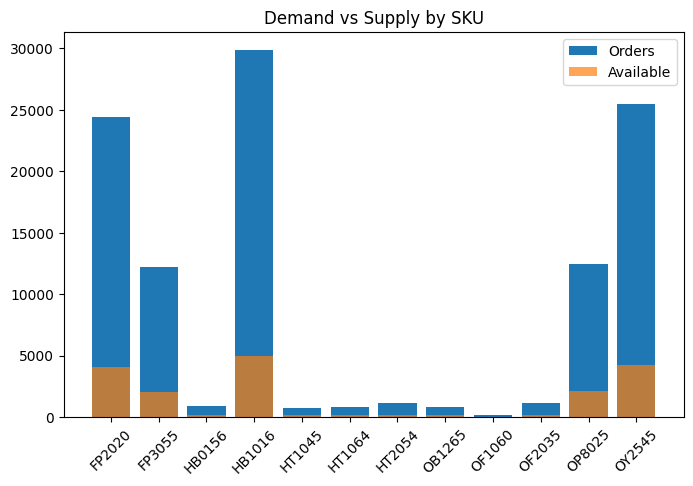

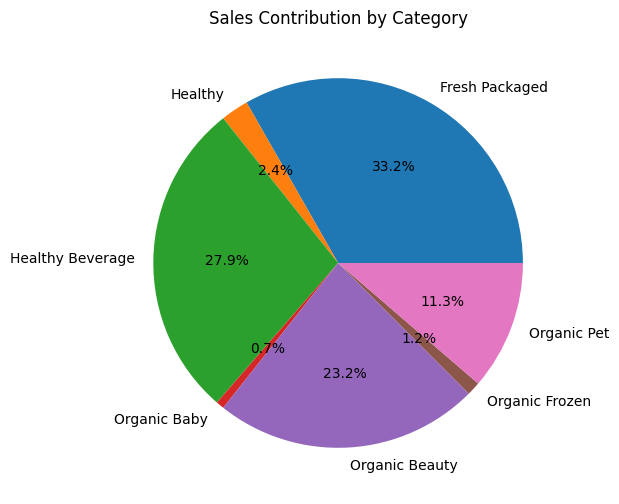

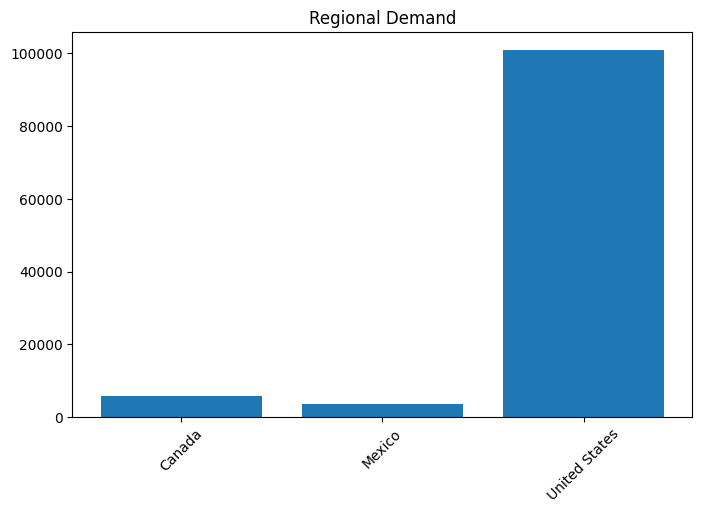

In [10]:
# ----------------------
# 8. Visualizations
# ----------------------
# Inventory vs Orders
plt.figure(figsize=(8,5))
plt.bar(demand_supply["SKU"], demand_supply["Qty Ordered"], label="Orders")
plt.bar(demand_supply["SKU"], demand_supply["Available"], alpha=0.7, label="Available")
plt.xticks(rotation=45)
plt.title("Demand vs Supply by SKU")
plt.legend()
plt.show()

# Sales by Category
plt.figure(figsize=(6,6))
plt.pie(sales_by_category["Sales $"], labels=sales_by_category["Category"], autopct='%1.1f%%')
plt.title("Sales Contribution by Category")
plt.show()

# Regional Demand
plt.figure(figsize=(8,5))
plt.bar(regional_demand["Country"], regional_demand["Qty Ordered"])
plt.title("Regional Demand")
plt.xticks(rotation=45)
plt.show()

# Key Insights & Recommendations

## Supply Chain Analysis Summary

### Critical Supply Shortages:
- **HB1016**: Shortage of 24,868 units (highest gap)
- **OY2545**: Shortage of 21,248 units 
- **FP2020**: Shortage of 20,316 units
- **OP8025**: Shortage of 10,367 units
- **FP3055**: Shortage of 10,158 units

### Production Plan Efficiency:
✅ **Good News**: Current production plan will cover most of the demand gaps with small surpluses for most SKUs.

- Most SKUs will have **negative remaining gaps** (meaning production plan exceeds shortages)
- Only minor adjustments needed to optimize production levels

### Market Insights:
- **United States** dominates demand (91.7% of total orders)
- **Fresh Packaged** products generate highest revenue (33.2% of sales)
- **Customer1** is the top customer contributing 44.8% of total sales

### Recommendations:
1. **Prioritize production** for HB1016, OY2545, and FP2020 (highest shortages)
2. **Focus on US market** - 92% of demand comes from United States
3. **Strengthen relationship** with Customer1 (largest revenue contributor)
4. **Monitor Kern warehouse** capacity - handles 100% of operations